In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


 Generating batches of tensor image data with real-time data augmentation.

In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1/255.,              
    brightness_range=[0.1, 0.7], 
    width_shift_range=0.5,       
    rotation_range=90,           
    horizontal_flip=True,        
    vertical_flip=True,          
    validation_split=0.15       
)

In [3]:
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory('/content/drive/MyDrive/Datasets/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory('/content/drive/MyDrive/Datasets/valid',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 2550 images belonging to 6 classes.
Found 77 images belonging to 6 classes.


# Experiment-1

### Building CNN  4 CNN layers, no dropout

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2
from tensorflow.keras.layers import BatchNormalization

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 63, 63, 64)       2

In [5]:
!pip install livelossplot

### Experiment-1 Training and validation accuracy, and loss

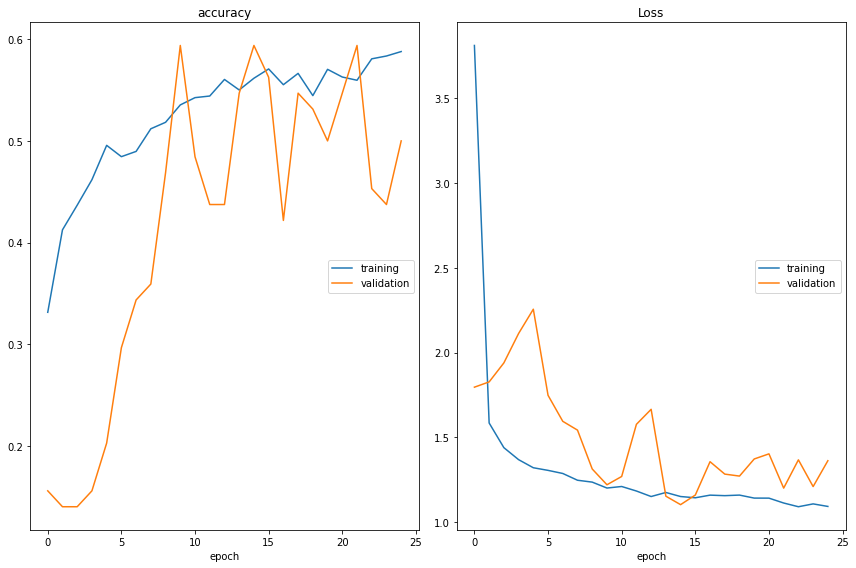

accuracy
	training         	 (min:    0.332, max:    0.588, cur:    0.588)
	validation       	 (min:    0.141, max:    0.594, cur:    0.500)
Loss
	training         	 (min:    1.091, max:    3.810, cur:    1.093)
	validation       	 (min:    1.104, max:    2.256, cur:    1.363)
CPU times: user 10min 49s, sys: 27 s, total: 11min 16s
Wall time: 19min 20s


In [6]:
%%time

from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

In [7]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/drive/MyDrive/Datasets/valid',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             shuffle=False,
                                             seed=42)


Found 521 images belonging to 6 classes.


In [8]:
model.load_weights('img_model.weights.best.hdf5')

predict_class=model.predict(testgen) 
predicted_classes=np.argmax(predict_class,axis=1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

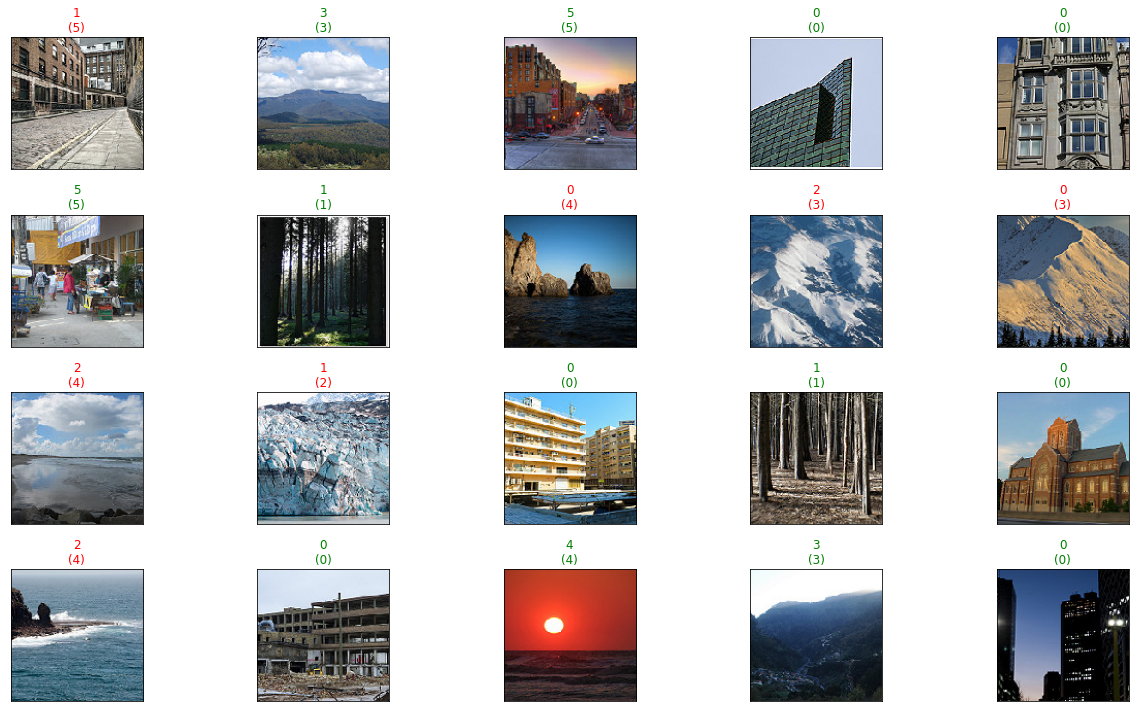

In [10]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [11]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 53.55%


Precision    Recall   F-Score  Support
1   0.570175  0.928571  0.706522     70.0
2   0.657895  0.625000  0.641026     80.0
0   0.476190  0.687023  0.562500    131.0
3   0.537500  0.537500  0.537500     80.0
4   0.681818  0.187500  0.294118     80.0
5   0.400000  0.200000  0.266667     80.0

# Experiment-2

### Building CNN  4 CNN layers, dropout=0.2, adding batchnorm 

In [12]:
model1 = Sequential()

model1.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

model1.add(Conv2D(32, (3,3), activation='relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D((2,2)))
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(1024, activation='relu'))
model1.add(Dense(6, activation='softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                  

### Experiment-2 Training and validation accuracy, and loss

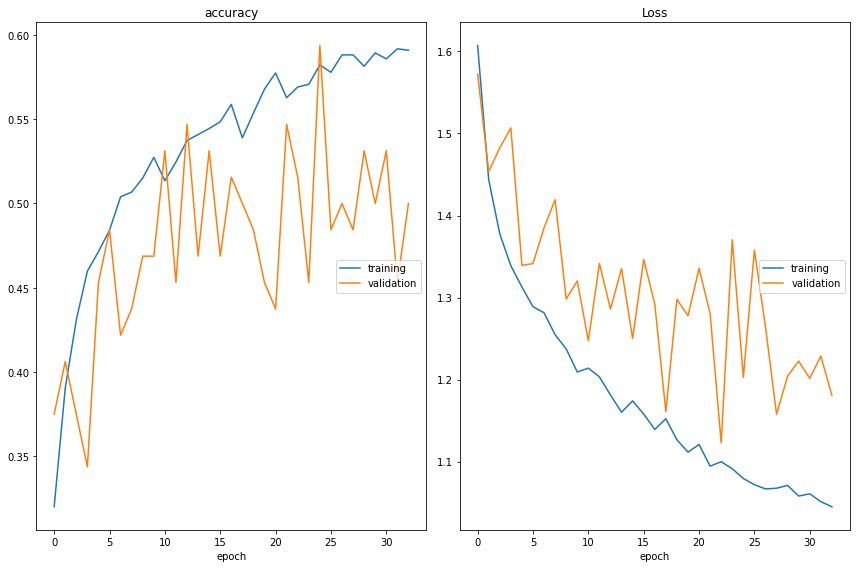

accuracy
	training         	 (min:    0.320, max:    0.592, cur:    0.591)
	validation       	 (min:    0.344, max:    0.594, cur:    0.500)
Loss
	training         	 (min:    1.045, max:    1.607, cur:    1.045)
	validation       	 (min:    1.123, max:    1.572, cur:    1.181)
CPU times: user 13min 44s, sys: 33.4 s, total: 14min 17s
Wall time: 16min 43s


In [13]:
%%time

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model1.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

In [14]:
model1.load_weights('img_model.weights.best.hdf5')

predict_class1=model1.predict(testgen) 
predicted_classes1=np.argmax(predict_class1,axis=1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

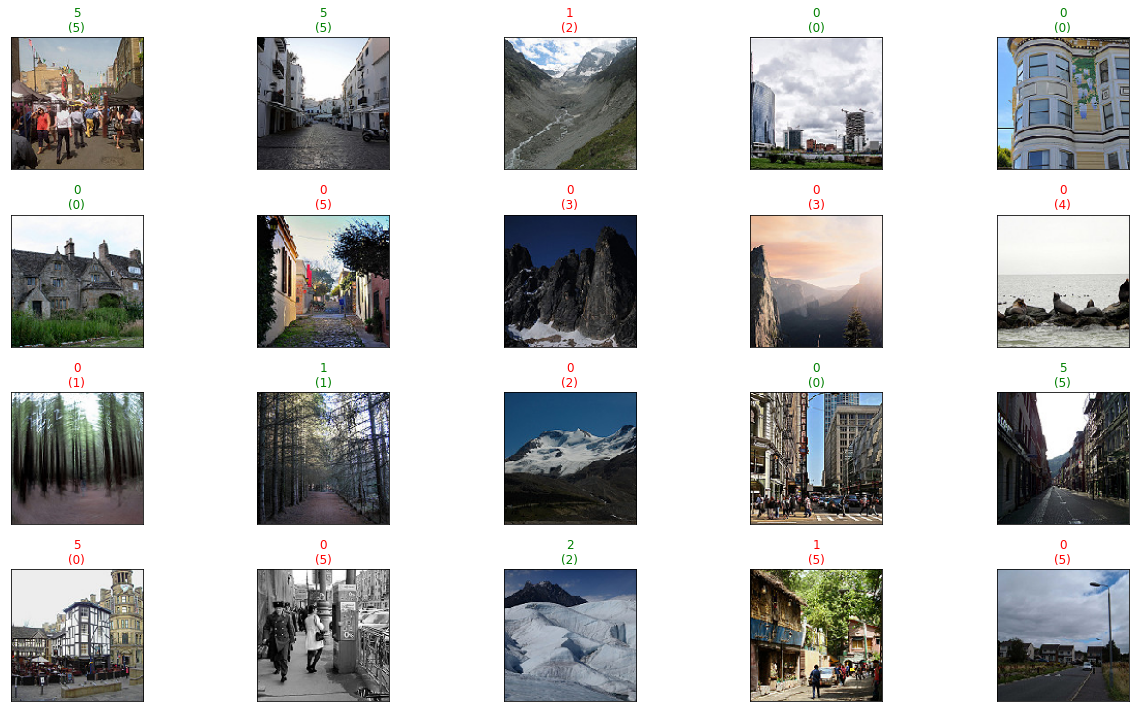

In [15]:
plot_predictions(true_classes, predicted_classes1, testgen, class_indices)

In [16]:
display_results(true_classes, predicted_classes1, class_indices.values())

Overall Categorical Accuracy: 53.17%


Precision    Recall   F-Score  Support
1   0.688172  0.914286  0.785276     70.0
0   0.416327  0.778626  0.542553    131.0
2   0.590909  0.487500  0.534247     80.0
3   0.688889  0.387500  0.496000     80.0
5   0.489796  0.300000  0.372093     80.0
4   0.739130  0.212500  0.330097     80.0

# Experiment-3

### Building CNN ,4 CNN layers, dropout=0.2, adding batchnorm, adding glorot uniform

In [22]:
from keras import initializers
from tensorflow.keras.layers import BatchNormalization


model2 = Sequential()


model2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer=initializers.glorot_uniform(seed=None), input_shape=(128, 128, 3)))

model2.add(Conv2D(32, (3,3), activation='relu', kernel_initializer=initializers.glorot_uniform(seed=None)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2,2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=initializers.glorot_uniform(seed=None)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2,2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=initializers.glorot_uniform(seed=None)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D((2,2)))
model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(6, activation='softmax'))

model2.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 batch_normalization_3 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 63, 63, 64)       

### Experiment-3 Training and validation accuracy, and loss

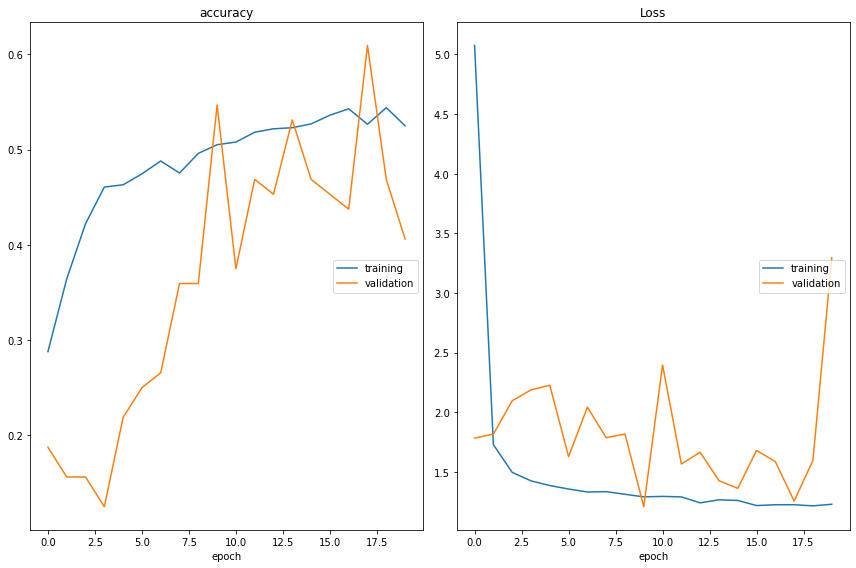

accuracy
	training         	 (min:    0.288, max:    0.544, cur:    0.525)
	validation       	 (min:    0.125, max:    0.609, cur:    0.406)
Loss
	training         	 (min:    1.217, max:    5.075, cur:    1.230)
	validation       	 (min:    1.209, max:    3.295, cur:    3.295)
CPU times: user 8min 36s, sys: 21 s, total: 8min 57s
Wall time: 10min 41s


In [23]:
%%time

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model2.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

In [24]:
model2.load_weights('img_model.weights.best.hdf5')

predict_class2=model2.predict(testgen) 
predicted_classes2=np.argmax(predict_class2,axis=1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

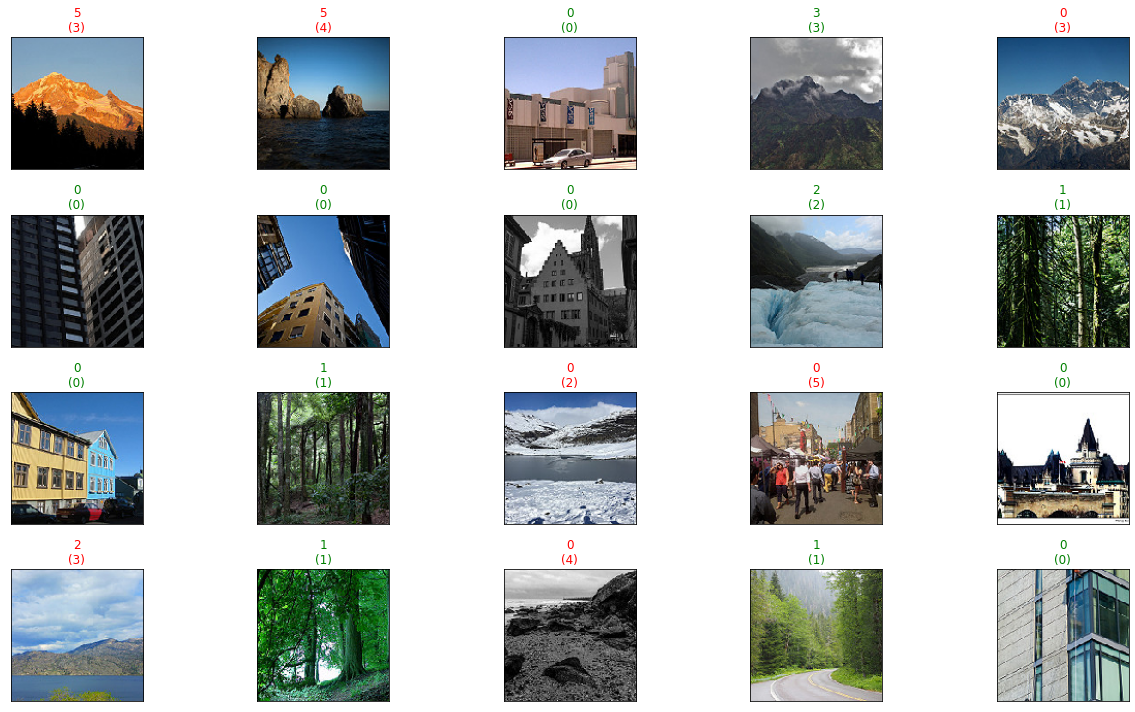

In [25]:
plot_predictions(true_classes, predicted_classes2, testgen, class_indices)

In [26]:
display_results(true_classes, predicted_classes2, class_indices.values())

Overall Categorical Accuracy: 48.37%


Precision    Recall   F-Score  Support
1   0.784810  0.885714  0.832215     70.0
0   0.379747  0.916031  0.536913    131.0
3   0.589286  0.412500  0.485294     80.0
2   0.611111  0.275000  0.379310     80.0
4   0.478261  0.137500  0.213592     80.0
5   0.363636  0.050000  0.087912     80.0

# Experiment-4

### Building CNN ,6 CNN layers, dropout=0.2, adding batchnorm, no dropout

In [27]:
model3 = Sequential()

model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128, 128, 3)))

model3.add(Conv2D(32, (3,3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2)))

model3.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2,2)))

model3.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model3.add(Conv2D(128, (3,3), activation='relu'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D((2,2)))

model3.add(Flatten())
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(6, activation='softmax'))

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 batch_normalization_6 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 61, 61, 64)       

### Experiment-4 Training and validation accuracy, and loss

In [28]:
from tensorflow.keras.optimizers import Adam

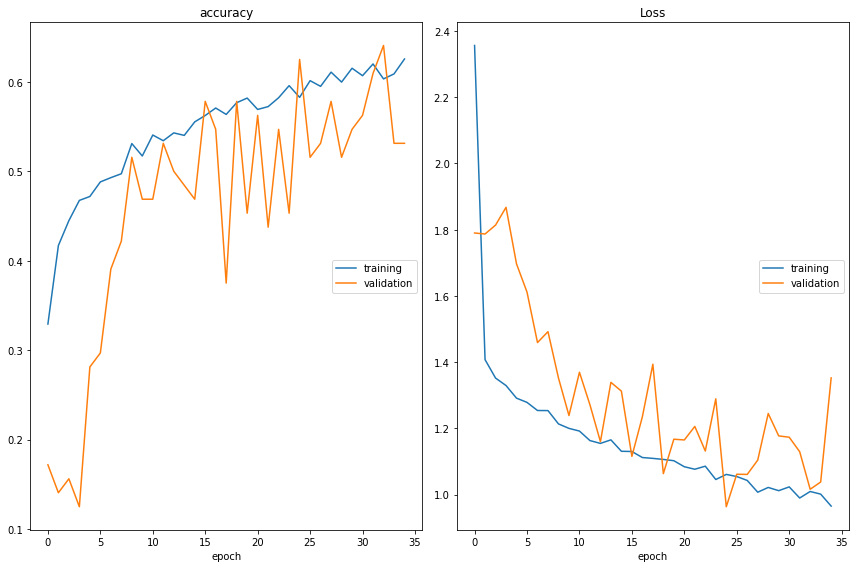

accuracy
	training         	 (min:    0.329, max:    0.625, cur:    0.625)
	validation       	 (min:    0.125, max:    0.641, cur:    0.531)
Loss
	training         	 (min:    0.966, max:    2.356, cur:    0.966)
	validation       	 (min:    0.964, max:    1.868, cur:    1.353)
CPU times: user 15min 27s, sys: 38.7 s, total: 16min 6s
Wall time: 18min 54s


In [29]:
%%time

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model3.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

In [30]:
model3.load_weights('img_model.weights.best.hdf5')

predict_class3=model3.predict(testgen) 
predicted_classes3=np.argmax(predict_class3,axis=1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

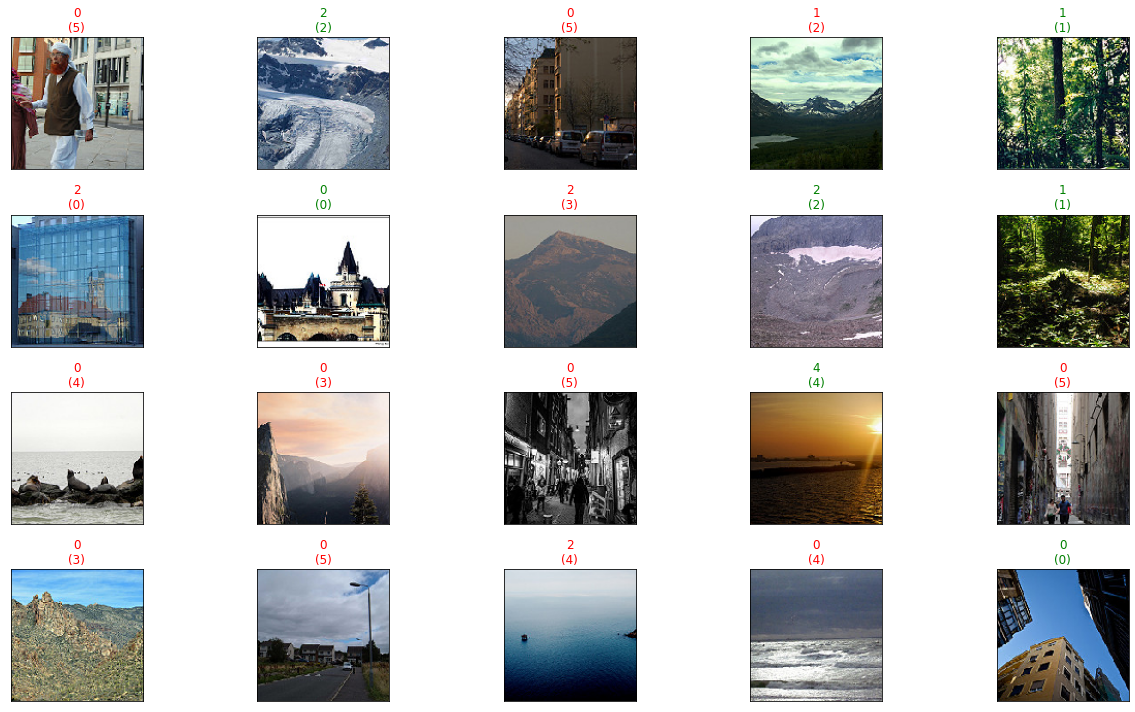

In [31]:
plot_predictions(true_classes, predicted_classes3, testgen, class_indices)

In [32]:
display_results(true_classes, predicted_classes3, class_indices.values())

Overall Categorical Accuracy: 49.90%


Precision    Recall   F-Score  Support
1   0.644231  0.957143  0.770115     70.0
0   0.392857  0.839695  0.535280    131.0
2   0.512821  0.500000  0.506329     80.0
3   0.794118  0.337500  0.473684     80.0
4   0.750000  0.150000  0.250000     80.0
5   0.444444  0.050000  0.089888     80.0

# Conclusion

Experiment 1 shows overall accuracy of 53.55%.

Experiment-2 shows overall accuracy of 53.17%.

Experiment-3 shows overall accuracy of 48.37%.

Experiment-4 shows overall accuracy of 49.90%.

For Experiment-4, tried diffrent optimizers Adam, SGD, and RMSprop. Moreover, used more convolution layers and removed dropout. The result shown is for Adam oprimizer. In the Experiment the highest Accuracy was found for the same architecture using RMSprop optimizer, which was around 62%, SGD showed accuracy around 45%.